# PC setting

In [2]:
# !pip install -r requirements_uavUnet.txt
from google.colab import drive
drive.mount('/content/drive')

if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_properties = torch.cuda.get_device_properties(device)
    gpu_memory_size = gpu_properties.total_memory / 1024 ** 3  # Convert bytes to gigabytes
    print(f"GPU Memory Size: {gpu_memory_size:.2f} GB")
else:
    print("GPU is not available.")


Mounted at /content/drive
GPU Memory Size: 14.75 GB


In [3]:
%cd /content/drive/MyDrive/Forest/src/

/content/drive/MyDrive/Forest/src


# Import modules

In [4]:


import os, glob, sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import random
from PIL import Image

# print(f"GPU Memory Usage: {get_gpu_memory_usage():.2f} GiB\n")
# print("Allocated Tensors:")
# print_allocated_tensors()

import segment_model_training
import importlib
importlib.reload(segment_model_training)
import cv2
from matplotlib import pyplot as plt

from segment_model_training import calculate_statistics,LoadDataSet,get_train_transform
from fpathutils import copyLocaliImages, get_mskPath
# importlib.reload(argmentDataset)
# importlib.reload(get_train_transform)

GPU Memory Size: 14.75 GB
GPU Memory Size: 14.75 GB


# LoadDatasets

In [10]:

datasetName = "Forest tsumura 2 50m P4Pv2"
treeType = "cypress"
cropSize = 1024
lapSize=512

orgDir = f"03_datasetforModel\\{datasetName}_{treeType}\\org_crop4Corner_5120_3072_Size{cropSize}_lap{lapSize}".replace("\\","/")
orgPaths = glob.glob(orgDir + "/*.*")

len(orgPaths)

# フォルダのパスを指定して統計量を計算
# mean_values, std_deviation = calculate_statistics(orgDir)
mean_values, std_deviation = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
print("正規化ずみ平均値:", mean_values)
print("正規化ずみ標準偏差:", std_deviation)


正規化ずみ平均値: (0.485, 0.456, 0.406)
正規化ずみ標準偏差: (0.229, 0.224, 0.225)


In [11]:

# calculate_statistics(orgPaths)

In [18]:

orgDataset_count = len(glob.glob(orgDir + "/*.*"))

rotate_270per90 = True
flipMirror = True

# orgDir = segment_model_training.argmentDataset(orgDir, rotate=rotate_270per90, flipMirror=True)
# segment_model_training.main("cedar",2)


workDir = "./04_trainingModel"
TRAIN_PATH = workDir + f'/{datasetName}_{treeType}/'
os.makedirs(TRAIN_PATH, exist_ok=True)
orgDataset_count

168

In [20]:

orgPaths = glob.glob(orgDir + "/*.*")
img = Image.open(orgPaths[0])
mskPaths = [get_mskPath(orgPath) for orgPath in orgPaths]
print(len(orgPaths),len(mskPaths))

# orgDir = copyLocaliImages(orgDir, f"C:\\datas\\uav_cnn_{treeType}")
# orgPaths = glob.glob(orgDir + "/*.*")


print(orgDir)

168 168
03_datasetforModel/Forest tsumura 2 50m P4Pv2_cypress/org_crop4Corner_5120_3072_Size1024_lap512


# PSQL connect

In [ ]:
import psql_connect
importlib.reload(psql_connect)

engine, conn, engineSQL = psql_connect.getPSQL(databaseName="cnn_segment", port="5432", ownerName="matsuilocal")

psql_connect.createTB_UnetDatasetUAV()
psql_connect.createTB_UnetTrainingUAV()

postgresql+psycopg2://matsuilocal:kuLcSkn2/@localhost:5432/cnn_segment
postgresql+psycopg2://matsuilocal:kuLcSkn2/@localhost:5432/cnn_segment
postgresql+psycopg2://matsuilocal:kuLcSkn2/@localhost:5432/cnn_segment


In [ ]:
from sqlalchemy import create_engine, Table, Column, Integer, String, Float, MetaData
from sqlalchemy.orm import sessionmaker

# Define the metadata and the table
metadata = MetaData()
unet_dataset_uav = Table('unet_dataset_uav', metadata,
                         Column('id', Integer, primary_key=True),
                         Column('datasetName', String),
                         Column('classType', String),
                         Column('width', Integer),
                         Column('height', Integer),
                         Column('lapSize', Integer),
                         Column('original_dataset_count', Integer),
                         Column('argment_rotate', String),
                         Column('argment_flipMirror', String),
                         Column('datasetDir', String),
                         Column('dataset_count', Integer),
                         Column('mean', String),
                         Column('std', String),
                     )
import ast

select_SQL = "select * from unet_dataset_uav;"

df_db = pd.read_sql(sql=select_SQL, con=engineSQL)
if not str(list(mean_values)) in list(df_db["mean"]):
# mean_values_fromDB = ast.literal_eval(df_db.loc[0,"mean"])
    # Create a session
    Session = sessionmaker(bind=engine)
    session = Session()

    # Create a new row to insert
    new_row = unet_dataset_uav.insert().values(
        datasetName=datasetName,
        classType=treeType,
        width=img.width,
        height=img.height,
        lapSize=lapSize,
        original_dataset_count=orgDataset_count,
        argment_rotate=rotate_270per90,
        argment_flipMirror=flipMirror,
        datasetDir=orgDir,
        dataset_count=len(orgPaths),
        mean=str(list(mean_values)),
        std=str(list(std_deviation)),
    )
    print(new_row)

    try:
        # Execute the insert statement
        session.execute(new_row)

        # Commit the changes
        session.commit()

        # Close the session
        session.close()
    except Exception as e:
        print(e)
        session.close()

In [ ]:
datasetID = int(df_db["id"][0])


getDatasetParam_SQL = f"select * from unet_dataset_uav where id={4};"
df = pd.read_sql(getDatasetParam_SQL,engine)
df

,id,datasetName,classType,width,height,lapSize,original_dataset_count,argment_rotate,argment_flipMirror,datasetDir,dataset_count,mean,std
0,4,Forest tsumura 2 50m P4Pv2,cypress,1024,1024,512,168,True,True,C:\datas\uav_cnn_cypress\org_crop4Corner_5120_...,2016,"[0.2987488396251448, 0.5321506065700683, 0.402...","[0.1450076779870688, 0.21275673444316853, 0.19..."


In [ ]:
orgDir = df["datasetDir"].iloc[0]
orgDir

'C:\\datas\\uav_cnn_cypress\\org_crop4Corner_5120_3072_Size1024_lap512_rotate_flipMirror'

# Dataset define

In [37]:
import segment_model_training
importlib.reload(segment_model_training)

print(orgDir.replace("\\","\\\\"))
train_dataset = segment_model_training.LoadDataSet(orgDir)
# train_dataset = LoadDataSet(orgDir.replace("\\","\\\\")+"\\")
print("images count\t",train_dataset.__len__())

org, msk = train_dataset.__getitem__(3)


segment_model_training.printArrayStatics(org)
segment_model_training.printArrayStatics(msk)

GPU Memory Size: 14.75 GB
03_datasetforModel/Forest tsumura 2 50m P4Pv2_cypress/org_crop4Corner_5120_3072_Size1024_lap512
images count	 168
torch.Size([3, 1024, 1024]) tensor(1.) tensor(0.4079) tensor(0.)
tensor([0.0000, 0.0040, 0.0079, 0.0119, 0.0159, 0.0198])
torch.Size([1, 1024, 1024]) tensor(1.) tensor(0.9175) tensor(0.)
tensor([0., 1.])


In [38]:

BATCHSIZE = 2

#データ前処理
split_ratio = 0.4
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))

print(f"train count : {(train_size)}")
print(f"valid count : {(valid_size)}")


train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_data, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=BATCHSIZE)


train count : 101
valid count : 67


# Models module Load

In [39]:
!pip install segmentation_models_pytorch

from unet_model import UNet, DiceBCELoss, DiceLoss, IoU, save_ckp, load_ckp
from pre_segmentation_model import UnetModel, calculate_iou, validateModel


import segmentation_models_pytorch as smp

import pre_segmentation_model
importlib.reload(pre_segmentation_model)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<module 'pre_segmentation_model' from '/content/drive/MyDrive/Forest/src/pre_segmentation_model.py'>

In [40]:
encoder_name = "resnet34"
encoder_weight = "imagenet"
DEVICE = "cuda"

model = pre_segmentation_model.UnetModel(encoder_name, encoder_weight, in_ch=3, outClass=1, activationName="softmax2d")
modelID = "class-{}_data{}_batch{}_epoch{}_model{}".format(treeType,train_dataset.__len__(), BATCHSIZE, num_epochs, encoder_name + "-" + encoder_weight)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# optimizer = torch.optim.Adam([dict(model.parameters(),lr = 1e-3))])
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])

criterion = DiceLoss()
accuracy_metric = IoU()
# valid_loss_min = np.Inf
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]


torch.cuda.empty_cache()
# CuDNNを使用したネットワークのベンチマークを有効にし、パフォーマンスを最適化します。
torch.backends.cudnn.benchmark = True

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE
)


In [ ]:
checkpoint_path = os.path.join(workDir,f'model_{treeType}_chkpoint_')
best_model_path = os.path.join(workDir,f'model_{treeType}_bestmodel.pt')
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

print(checkpoint_path)
print(best_model_path)

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []
losses_value = 0


def get_gpu_memory_usage():
    """GPUメモリの使用量を取得する関数"""
    return torch.cuda.memory_allocated() / 1024**3  # GiB単位で返す

def print_allocated_tensors():
    """GPUメモリを占有している変数の一覧を表示する関数"""
    tensor_list = torch.cuda.memory_summary()  # 現在GPUメモリに割り当てられているテンソルの一覧を取得
    print(tensor_list)

# 使用例
print(f"GPU Memory Usage: {get_gpu_memory_usage():.2f} GiB\n")
# print_allocated_tensors()

In [46]:
patience = 5 # 5Epcoch以上連続でモデル精度が向上しなければEarly Stopping
early_stop_counter = 0

max_score = 0
for i in range(2):
    
    print(f"Epoch:{i+1}")
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    
    # IoUスコアが最高値が更新されればモデルを保存
    if max_score < valid_logs["iou_score"]:
        max_score = valid_logs["iou_score"]
        torch.save(model, checkpoint_path)
        print("Model saved!")
        early_stop_counter = 0

    else:
        early_stop_counter += 1
        print(f"not improve for {early_stop_counter}Epoch")
        if early_stop_counter==patience:
            print(f"early stop. Max Score {max_score}")
            break

    # 適当なタイミングでlearning rateの変更
    if i == 10:
        optimizer.param_groups[0]["lr"] = 1e-5
        print("Decrease decoder learning rate to 1e-5")

Epoch:1
valid: 100%|██████████| 34/34 [00:06<00:00,  4.94it/s, dice_loss - nan, iou_score - nan]
not improve for 1Epoch
Epoch:2
valid: 100%|██████████| 34/34 [00:06<00:00,  5.03it/s, dice_loss - nan, iou_score - nan]
not improve for 2Epoch


In [ ]:
workDir = "./04_trainingModel"

from segment_model_training import showPred
importlib.reload(segment_model_training)



workDir = os.path.join(workDir, modelID) + "\\"
os.makedirs(workDir, exist_ok=True)

img_show, msk_show = random.choice(valid_data)
# img_show[img_show<=0]=0
print("0 org_test.unique()",np.unique(img_show)[:50]) 


img_pred = torch.stack([org, org])
# pred = model(img_show.cuda())
pred = torch.sigmoid(model(img_pred.cuda()))
print("0 pred_sig.unique()",np.unique(pred.data.cpu())) 
pred = pred[0][0]
print("predShape",pred.shape,pred.data.cpu().dtype)
print(msk_show.dtype)
print("0 pred.unique()",np.unique(pred.data.cpu())) 
img_show = img_show.cuda()

print(workDir)
print(modelID)
segment_model_training.showPred(img_show=img_show, msk_show=msk_show, pred=pred,
         mean_values=mean_values, std_deviation=std_deviation,
         workDir=workDir, epoch=1, modelID="testmodel",
         imgSave=True)    
print(org.shape)

# pred = model(org)[0][0]
# pred.shape

GPU Memory Size: 16.00 GB
0 org_test.unique() [0.         0.00411523 0.00823045 0.01234568 0.0164609  0.02057613
 0.02469136 0.02880658 0.03292181 0.03703704 0.04115226 0.04526749
 0.04938272 0.05349794 0.05761317 0.0617284  0.06584362 0.06995885
 0.07407407 0.0781893  0.08230453 0.08641975 0.09053498 0.09465021
 0.09876543 0.10288066 0.10699589 0.11111111 0.11522634 0.11934157
 0.12345679 0.12757201 0.13168724 0.13580246 0.1399177  0.14403293
 0.14814815 0.15226337 0.1563786  0.16049382 0.16460906 0.16872428
 0.17283951 0.17695473 0.18106996 0.18518518 0.18930042 0.19341564
 0.19753087 0.20164609]
0 pred_sig.unique() [0.73105854]
predShape torch.Size([1024, 1024]) torch.float32
torch.float32
0 pred.unique() [0.73105854]
./04_trainingModel\class-cypress_data168_batch2_epoch20_modelresnet34-imagenet\
class-cypress_data168_batch2_epoch20_modelresnet34-imagenet
img_show.shape (1024, 1024, 3)
msk_show.shape (1024, 1024)
output.shape torch.Size([1024, 1024])
pred.shape torch.Size([1024, 102

In [ ]:
data = {'dataset_Mean': mean_values, 'dataset_Std Deviation': std_deviation}
df_statics = pd.DataFrame(data)
# DataFrameをCSVファイルとして保存
df_statics.to_csv(workDir + f"statistics_{modelID}.csv", index=False)


In [ ]:
# del pre_segmentation_model
import pre_segmentation_model
importlib.reload(pre_segmentation_model)

<module 'pre_segmentation_model' from 'H:\\マイドライブ\\Forest\\src\\pre_segmentation_model.py'>

Epoch 1/20


description:  22%|██████▎                     | 15/67 [00:09<00:31,  1.66it/s]


KeyboardInterrupt: 

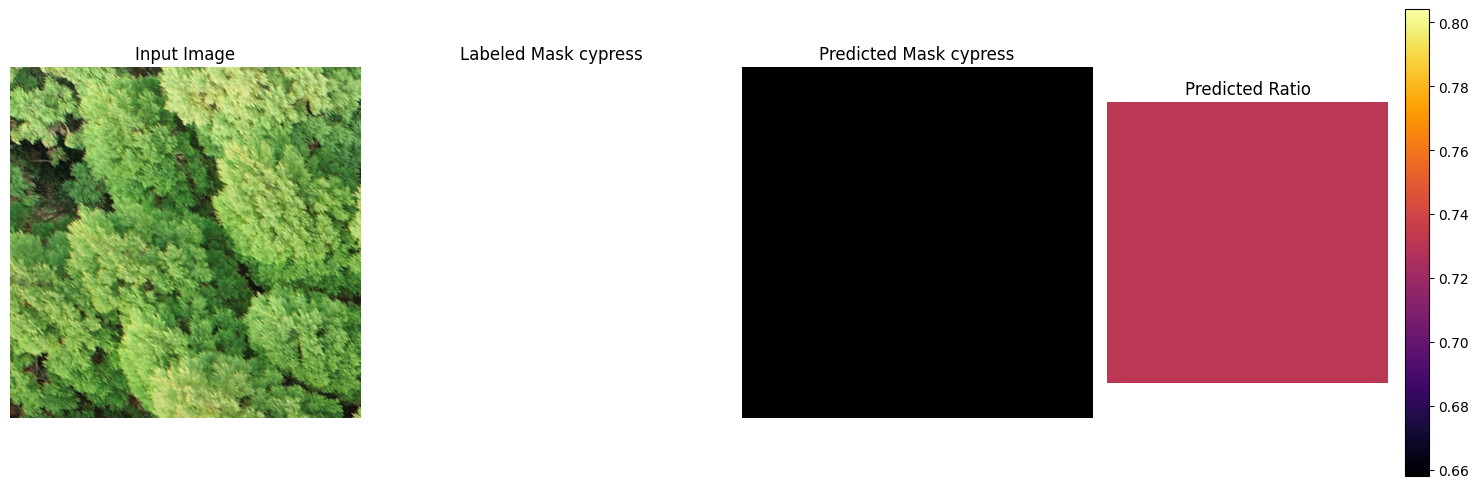

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    print(f"Epoch {str(epoch+1)}/{str(num_epochs)}")

#<---------------トレーニング---------------------->
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    train_loader_pbar = tqdm(train_loader, desc = 'description')

    #<---------------評価---------------------->
    losses_value, score = pre_segmentation_model.validateModel(model, train_loader_pbar, workDir=workDir,epoch=epoch,means=mean_values,stds=std_deviation, modelID=modelID)

    train_loss.append(losses_value)
    train_score.append(score)
    
    train_loader_pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")
    
    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}")
    print(f"Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}")

    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    print("CheckPoint Save",modelID)

    # checkpointの保存
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    
    # 評価データにおいて最高精度のモデルのcheckpointの保存
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = total_valid_loss[-1]
    
    print("")


    score = {
        # "epoch" : range(1,num_epochs+1),
        "train_Loss" : total_train_loss,
        "valid__Loss" : total_valid_loss,
        "train_scoreIoU" : total_train_score,
        "valid__scoreIoU" : total_valid_score,
        }

    import pandas as pd
    df_score = pd.DataFrame(score, index=range(1,len(total_train_loss)+1))
    df_score.to_csv(workDir + f"scoreSheet_{modelID}.csv")


